In [168]:
import numpy as np
import libpysal as ps
import missingno as msno
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.font_manager as fm
from matplotlib import font_manager, rc
import seaborn as sns
import warnings

warnings.simplefilter('ignore')

font_path = r'C:/Users/user/NanumFontSetup_TTF_ALL/NanumGothic.ttf'
font_name = font_manager.FontProperties(fname=font_path, size=18).get_name()
rc('font',family=font_name)

In [4]:
ped_data = pd.read_csv('./서울시_집계구_보행수요.csv',encoding="EUC-KR")
seoul_shp = gp.read_file('./data/서울시 행정구역 및 집계구 정보(SHP)/서울시_집계구_4326.shp',encoding="EUC-KR")
# pop_data = pd.read_csv('./data/pop/19년 12월 집계구코드별 평균생활인구수.csv')
display(seoul_shp.head())
display(ped_data.head)

,TOT_REG_CD,ADM_NM,ADM_CD,geometry
0,1101053010006,사직동,1101053,"POLYGON ((126.97033 37.57912, 126.97039 37.579..."
1,1101053010001,사직동,1101053,"POLYGON ((126.96613 37.57496, 126.96632 37.574..."
2,1101053010003,사직동,1101053,"POLYGON ((126.96645 37.57883, 126.96647 37.578..."
3,1101053010002,사직동,1101053,"POLYGON ((126.96877 37.57823, 126.96878 37.578..."
4,1101053010005,사직동,1101053,"POLYGON ((126.97399 37.57823, 126.97400 37.578..."


,TOT_REG_CD,ADM_NM,ADM_CD,공공기관,보육시설,사회복지시,버스정류장,버스승하차,지하철(1km,지하철거리,승하차평균,구별총생활,구별총생_1,상가수_집,log생활
0,1101053010006,사직동,1101053,8,2,0,5,1269,2,450,52315,367654,11859.806450,29.0,5.565
1,1101053010001,사직동,1101053,6,4,0,5,140,4,700,0,277143,8940.096774,7.0,5.443
2,1101053010003,사직동,1101053,10,6,0,13,492,4,600,34690,1245899,40190.290320,37.0,6.095
3,1101053010002,사직동,1101053,7,2,0,4,1390,3,450,52315,1373417,44303.774190,74.0,6.138
4,1101053010005,사직동,1101053,11,2,0,7,2165,3,300,52315,1038484,33499.483870,122.0,6.016


In [14]:
ped_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19153 entries, 0 to 19152
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TOT_REG_CD      19153 non-null  int64  
 1   ADM_NM          19153 non-null  object 
 2   ADM_CD          19153 non-null  int64  
 3   공공기관            19153 non-null  int64  
 4   보육시설            19153 non-null  int64  
 5   SOC_NUM         19153 non-null  int64  
 6   BUS_NUM         19153 non-null  int64  
 7   BUS_AVG         19153 non-null  int64  
 8   SUB_NUM         19153 non-null  int64  
 9   SUB_DIS         19153 non-null  int64  
 10  SUB_AVG         19153 non-null  int64  
 11  TOT_POP_GU      19153 non-null  int64  
 12  TOT_POP_GU_AVG  19153 non-null  float64
 13  SHOP_NUM        19143 non-null  float64
 14  log생활           19153 non-null  float64
dtypes: float64(3), int64(11), object(1)
memory usage: 2.2+ MB


In [15]:
seoul_shp.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 19153 entries, 0 to 19152
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   TOT_REG_CD  19153 non-null  object  
 1   ADM_NM      19153 non-null  object  
 2   ADM_CD      19153 non-null  object  
 3   geometry    19153 non-null  geometry
dtypes: geometry(1), object(3)
memory usage: 598.7+ KB


In [36]:
seoul_shp.to_crs(epsg=4326)
seoul_shp.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### 결측치 확인
- 상점의 수에 nan이 존재하여 0으로 대체

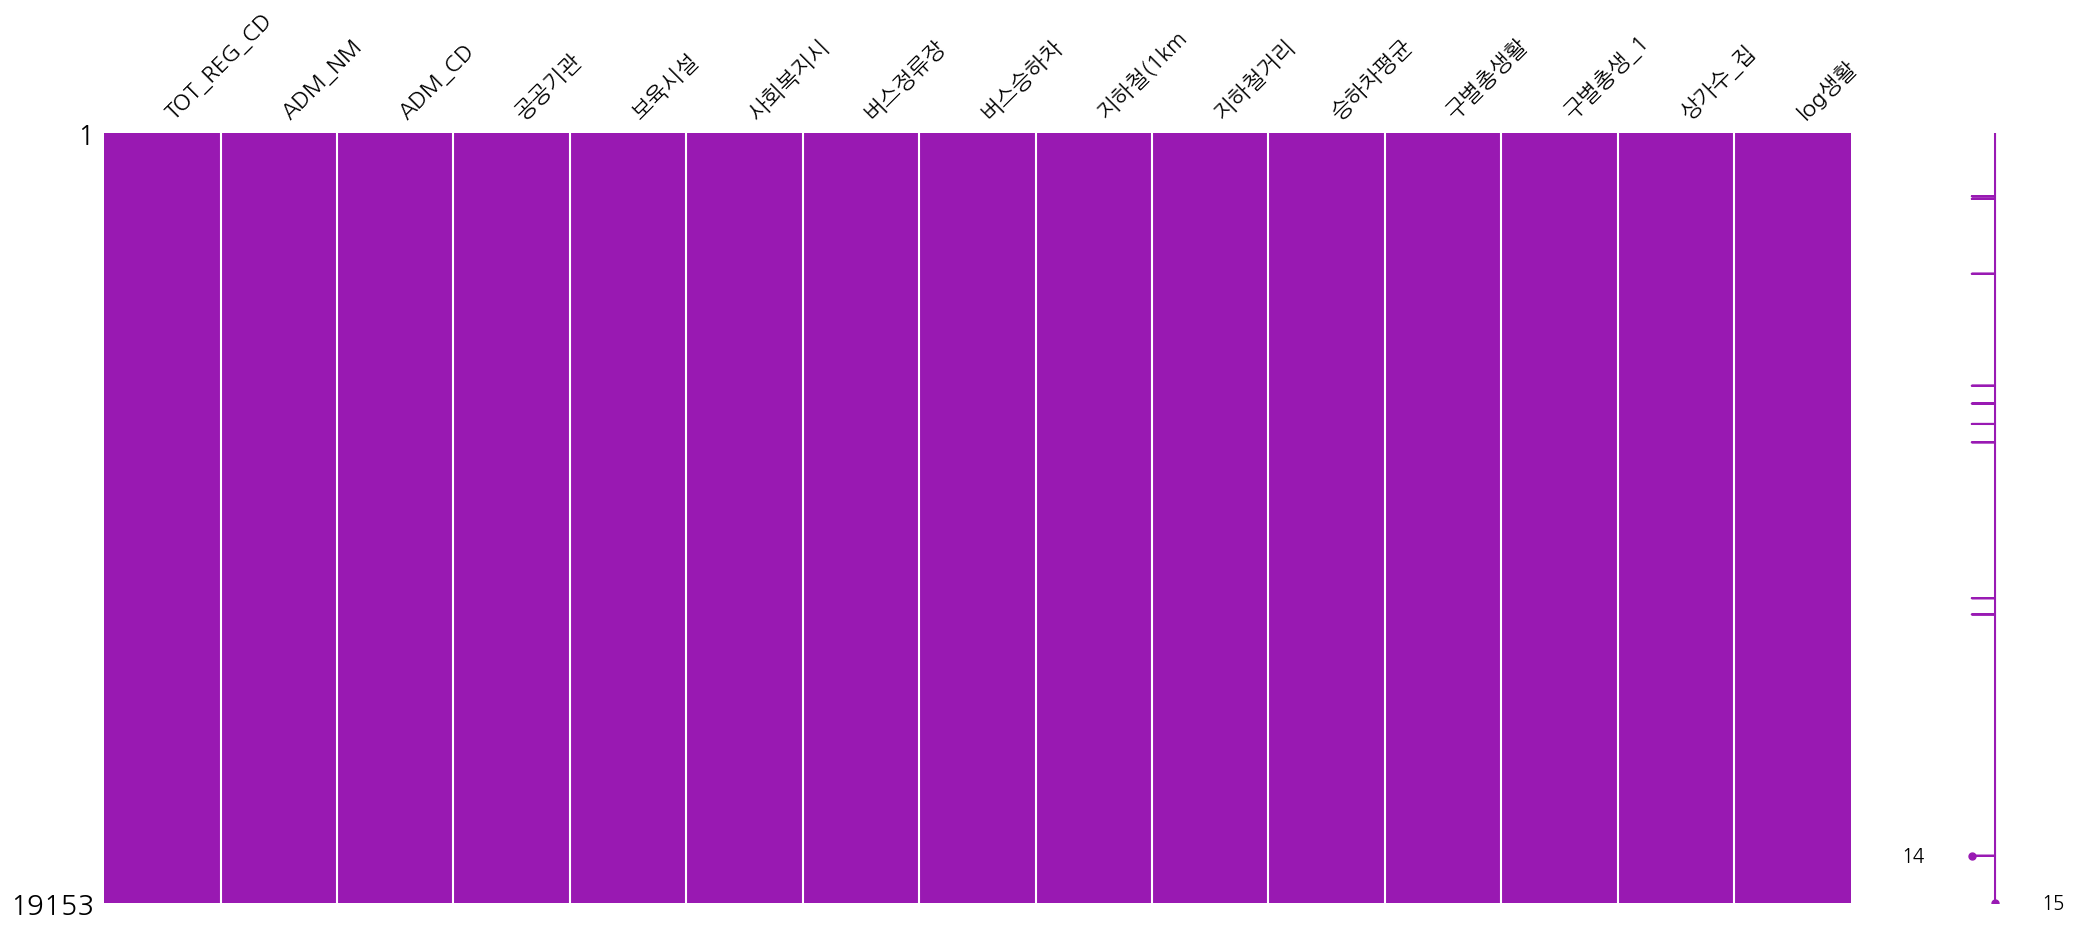

In [9]:
msno.matrix(df=ped_data,color=(0.6,0.1,0.7))
plt.show()

In [139]:
ped_data.isnull().sum()

TOT_REG_CD         0
ADM_NM             0
ADM_CD             0
공공기관               0
보육시설               0
SOC_NUM            0
BUS_NUM            0
BUS_AVG            0
SUB_NUM            0
SUB_DIS            0
SUB_AVG            0
TOT_POP_GU         0
TOT_POP_GU_AVG     0
SHOP_NUM          10
log생활              0
dtype: int64

In [144]:
ped_data['SHOP_NUM'].fillna(0,inplace=True)
ped_data['SHOP_NUM'].isnull().sum()

0

### Column명 변경
- 사회복지시 -> SOC_NUM
- 지하철(1km -> SUB_NUM
- 지하철 거리 -> SUB_DIS
- 버스정류장 -> BUS_NUM
- 버스승하차 -> BUS_AVG
- 승하차평균 -> SUB_AVG
- 구별총생활 -> TOT_POP_GU
- 구별총생_1 -> TOT_POP_GU_AVG
- 상가수_집 -> SHOP_NUM

TARGET VARIABLE : TOT_POP_GU_AVG

In [145]:
ped_data.rename(columns={'사회복지시':'SOC_NUM','지하철(1km':'SUB_NUM','지하철거리':'SUB_DIS'
                         ,'버스정류장':'BUS_NUM','버스승하차':'BUS_AVG','승하차평균':'SUB_AVG'
                         ,'구별총생활':'TOT_POP_GU','구별총생_1':'TOT_POP_GU_AVG','상가수_집':'SHOP_NUM'}
                        ,inplace=True)      
ped_data.columns

Index(['TOT_REG_CD', 'ADM_NM', 'ADM_CD', '공공기관', '보육시설', 'SOC_NUM', 'BUS_NUM',
       'BUS_AVG', 'SUB_NUM', 'SUB_DIS', 'SUB_AVG', 'TOT_POP_GU',
       'TOT_POP_GU_AVG', 'SHOP_NUM', 'log생활'],
      dtype='object')

### 데이터 분포 확인
#### 1. 지하철 거리

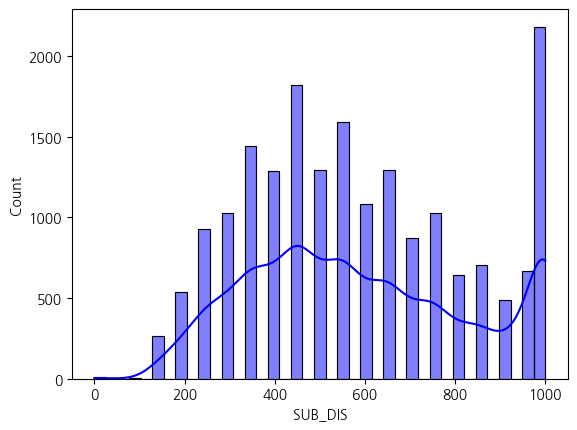

In [147]:
sns.histplot(data=ped_data,x='SUB_DIS',color='blue',kde=True)
plt.show()

#### 2. 버스 승하차
- 왼쪽으로 치우친 형태의 분포를 띄고 있다. 
- log함수를 이용하여 skew된 분포를 정규분포형태로 만들어주자.

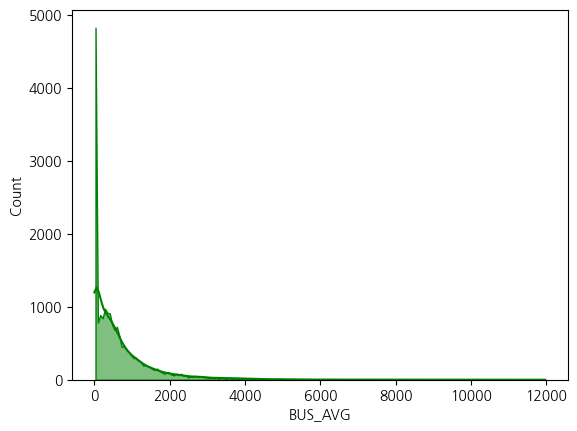

In [148]:
sns.histplot(data=ped_data,x='BUS_AVG',element="poly",color='green',kde=True)
plt.show()

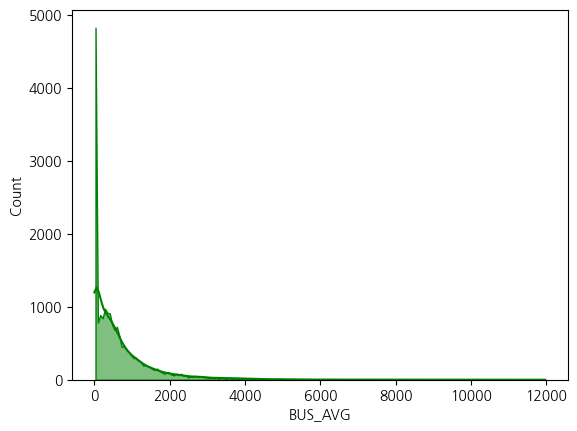

In [149]:
sns.histplot(data=ped_data,x='BUS_AVG',element="poly",color='green',kde=True)
plt.show()

#### 3. 지하철 평균
- 왼쪽으로 치우친 분포를 보이고 있다.
- log함수를 이용하여 정규분포 형태를 만들어주자.

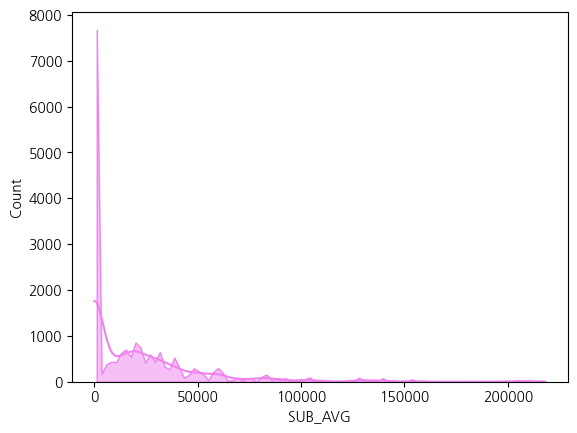

In [150]:
sns.histplot(data=ped_data,x='SUB_AVG',color='violet',element="poly",kde=True)
plt.show()

#### 4. 상가 수

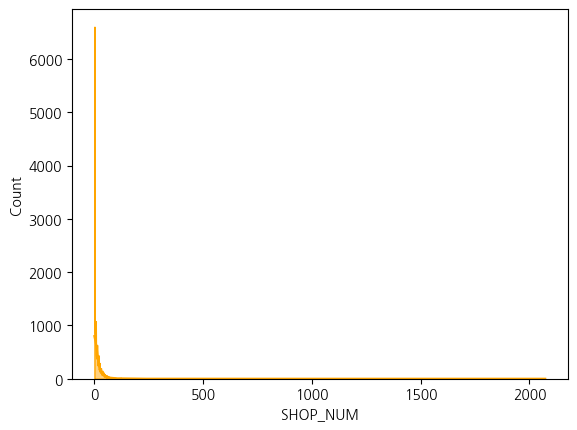

In [151]:
sns.histplot(data=ped_data,x='SHOP_NUM',color='orange',element="poly",kde=True)
plt.show()

#### 5. 구별총생활인구수 평균

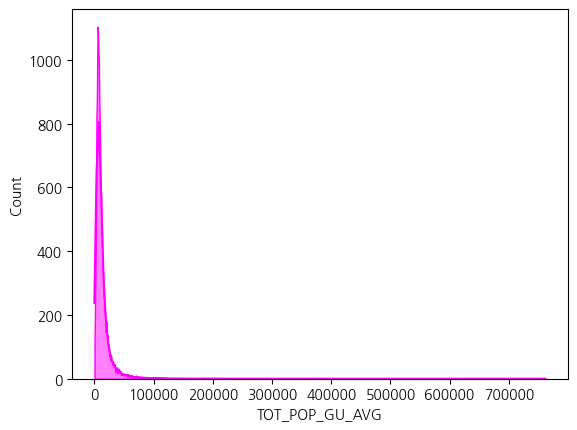

In [152]:
sns.histplot(data=ped_data,x='TOT_POP_GU_AVG',color='magenta',element="poly",kde=True)
plt.show()

In [153]:
# 현재 TOT_REG_CD가 int type이므로 str type으로 변경해주도록 한다.
# 차후 merge를 하기 위해서이다.
ped_data['TOT_REG_CD']= ped_data['TOT_REG_CD'].astype(str)

In [154]:
# prepare dataset
data = ped_data.merge(seoul_shp,left_on='TOT_REG_CD',right_on='TOT_REG_CD')
data.head()

,TOT_REG_CD,ADM_NM_x,ADM_CD_x,공공기관,보육시설,SOC_NUM,BUS_NUM,BUS_AVG,SUB_NUM,SUB_DIS,SUB_AVG,TOT_POP_GU,TOT_POP_GU_AVG,SHOP_NUM,log생활,ADM_NM_y,ADM_CD_y,geometry
0,1101053010006,사직동,1101053,8,2,0,5,1269,2,450,52315,367654,11859.806450,29.0,5.565,사직동,1101053,"POLYGON ((126.97033 37.57912, 126.97039 37.579..."
1,1101053010001,사직동,1101053,6,4,0,5,140,4,700,0,277143,8940.096774,7.0,5.443,사직동,1101053,"POLYGON ((126.96613 37.57496, 126.96632 37.574..."
2,1101053010003,사직동,1101053,10,6,0,13,492,4,600,34690,1245899,40190.290320,37.0,6.095,사직동,1101053,"POLYGON ((126.96645 37.57883, 126.96647 37.578..."
3,1101053010002,사직동,1101053,7,2,0,4,1390,3,450,52315,1373417,44303.774190,74.0,6.138,사직동,1101053,"POLYGON ((126.96877 37.57823, 126.96878 37.578..."
4,1101053010005,사직동,1101053,11,2,0,7,2165,3,300,52315,1038484,33499.483870,122.0,6.016,사직동,1101053,"POLYGON ((126.97399 37.57823, 126.97400 37.578..."


In [155]:
data.columns

Index(['TOT_REG_CD', 'ADM_NM_x', 'ADM_CD_x', '공공기관', '보육시설', 'SOC_NUM',
       'BUS_NUM', 'BUS_AVG', 'SUB_NUM', 'SUB_DIS', 'SUB_AVG', 'TOT_POP_GU',
       'TOT_POP_GU_AVG', 'SHOP_NUM', 'log생활', 'ADM_NM_y', 'ADM_CD_y',
       'geometry'],
      dtype='object')

In [156]:
essential_col=['TOT_REG_CD','공공기관','보육시설','SOC_NUM','BUS_NUM','BUS_AVG','SUB_NUM','SUB_DIS','SUB_AVG'
               ,'SHOP_NUM','geometry','TOT_POP_GU_AVG']
required_data = data.loc[:,essential_col]
required_data.head()

,TOT_REG_CD,공공기관,보육시설,SOC_NUM,BUS_NUM,BUS_AVG,SUB_NUM,SUB_DIS,SUB_AVG,SHOP_NUM,geometry,TOT_POP_GU_AVG
0,1101053010006,8,2,0,5,1269,2,450,52315,29.0,"POLYGON ((126.97033 37.57912, 126.97039 37.579...",11859.806450
1,1101053010001,6,4,0,5,140,4,700,0,7.0,"POLYGON ((126.96613 37.57496, 126.96632 37.574...",8940.096774
2,1101053010003,10,6,0,13,492,4,600,34690,37.0,"POLYGON ((126.96645 37.57883, 126.96647 37.578...",40190.290320
3,1101053010002,7,2,0,4,1390,3,450,52315,74.0,"POLYGON ((126.96877 37.57823, 126.96878 37.578...",44303.774190
4,1101053010005,11,2,0,7,2165,3,300,52315,122.0,"POLYGON ((126.97399 37.57823, 126.97400 37.578...",33499.483870


### Data 분포 변환

#### 1. 버스 이용객 평균

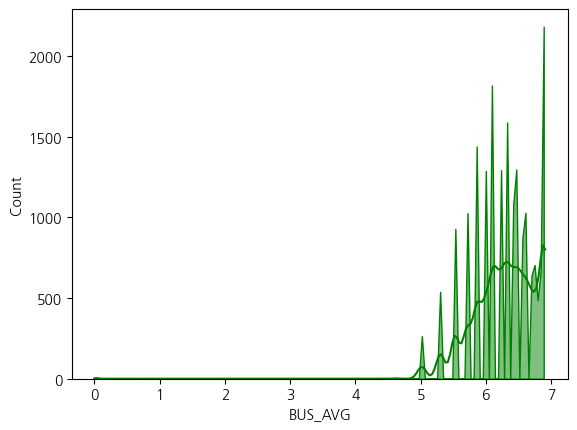

In [157]:
required_data.loc[:,'BUS_AVG'] = np.log1p(data['SUB_DIS'])
sns.histplot(data=required_data,x='BUS_AVG',element="poly",color='green',kde=True)
plt.show()

#### 2. 지하철 이용객 평균

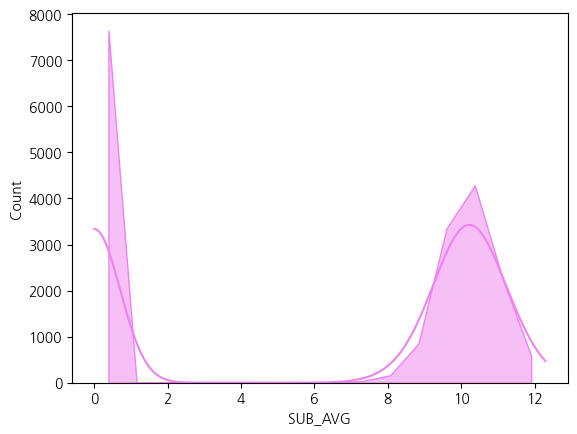

In [158]:
required_data.loc[:,'SUB_AVG'] = np.log1p(data['SUB_AVG'])
sns.histplot(data=required_data,x='SUB_AVG',color='violet',element="poly",kde=True)
plt.show()

#### 3. 상가 수

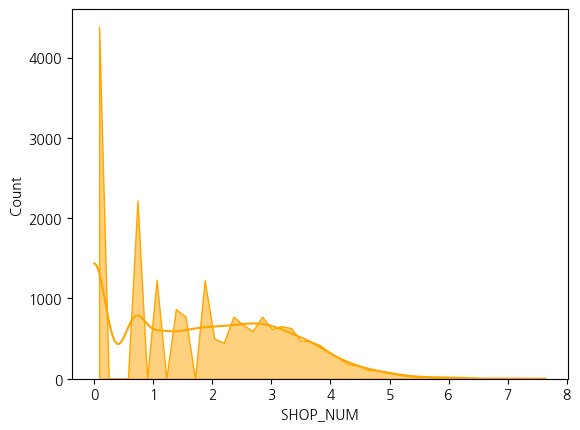

In [159]:
required_data.loc[:,'SHOP_NUM'] = np.log1p(data['SHOP_NUM'])
sns.histplot(data=required_data,x='SHOP_NUM',color='orange',element="poly",kde=True)
plt.show()

#### 4. 구별 총 생활인구 평균

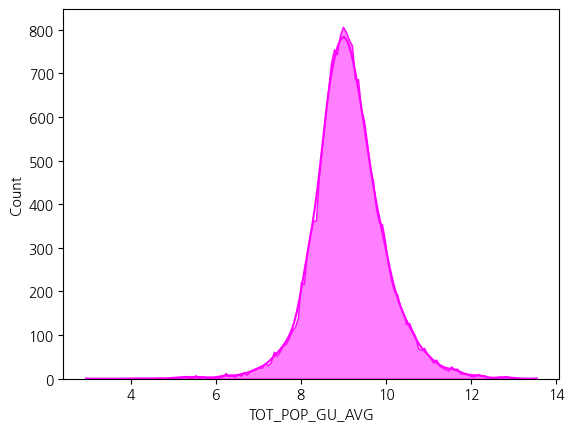

In [160]:
required_data.loc[:,'TOT_POP_GU_AVG'] = np.log1p(data['TOT_POP_GU_AVG'])
sns.histplot(data=required_data,x='TOT_POP_GU_AVG',color='magenta',element="poly",kde=True)
plt.show()

In [161]:
center = seoul_shp.centroid
X = pd.Series(center.x)
Y = pd.Series(center.y)
required_data.loc[:,'lon'] = X
required_data.loc[:,'lat'] = Y
required_data.head()

<ipython-input-161-9a120dbc1b30>:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = seoul_shp.centroid


,TOT_REG_CD,공공기관,보육시설,SOC_NUM,BUS_NUM,BUS_AVG,SUB_NUM,SUB_DIS,SUB_AVG,SHOP_NUM,geometry,TOT_POP_GU_AVG,lon,lat
0,1101053010006,8,2,0,5,6.111467,2,450,10.865058,3.401197,"POLYGON ((126.97033 37.57912, 126.97039 37.579...",9.380995,126.970311,37.578304
1,1101053010001,6,4,0,5,6.552508,4,700,0.000000,2.079442,"POLYGON ((126.96613 37.57496, 126.96632 37.574...",9.098414,126.965178,37.574151
2,1101053010003,10,6,0,13,6.398595,4,600,10.454236,3.637586,"POLYGON ((126.96645 37.57883, 126.96647 37.578...",10.601406,126.965513,37.576513
3,1101053010002,7,2,0,4,6.111467,3,450,10.865058,4.317488,"POLYGON ((126.96877 37.57823, 126.96878 37.578...",10.698848,126.969002,37.577092
4,1101053010005,11,2,0,7,5.707110,3,300,10.865058,4.812184,"POLYGON ((126.97399 37.57823, 126.97400 37.578...",10.419315,126.972772,37.578025


### 독립변수, 종속변수 설정

In [162]:
essential_col[1:-2]

['공공기관',
 '보육시설',
 'SOC_NUM',
 'BUS_NUM',
 'BUS_AVG',
 'SUB_NUM',
 'SUB_DIS',
 'SUB_AVG',
 'SHOP_NUM']

In [163]:
#Prepare Georgia dataset inputs
s_y = required_data['TOT_POP_GU_AVG'].values.reshape((-1,1))
s_X = required_data[essential_col[1:-2]].values
u = required_data['lon']
v = required_data['lat']
s_coords = list(zip(u,v))

### Train and Test set 분리

In [58]:
s_y = sample_data['구별총생활인구수(월평균)'].values.reshape((-1,1))
s_X = sample_data[['정류장수', '월평균승차수', '월평균하차수','lon','lat']].values
u = sample_data['lon']
v = sample_data['lat']
coords = list(zip(u,v))

# standardScaler적용

# scaler = StandardScaler()
# s_y = required_data['TOT_POP_GU_AVG']
# s_X = required_data[['정류장수', '월평균승차수', '월평균하차수','lon','lat']]

# train set과 test set으로 나누는 과정으로 보인다.
# 해당 모델에 교차 검증이 있는 것으로 알고 있다.

# test set은 20%, 
# x_train, x_valid, y_train, y_valid = train_test_split(s_X, s_y, test_size=0.2, shuffle=True,random_state=34)

# cal_u = x_train['lon'].values
# cal_v = x_train['lat'].values
# cal_coords = list(zip(cal_u,cal_v))

# pred_u = x_valid['lon'].values
# pred_v = x_valid['lat'].values
# pred_coords = list(zip(pred_u,pred_v))

# # 위도, 경도 column 제거
# # display(x_train.columns)
# x_train.drop(['lon','lat'],axis=1,inplace=True)
# x_valid.drop(['lon','lat'],axis=1,inplace=True)

# # array로 변환
# X_train = scaler.fit_transform(x_train.values)
# Y_train = scaler.fit_transform(y_train.values.reshape((-1,1)))
# X_valid = scaler.fit_transform(x_valid.values)
# Y_valid = scaler.fit_transform(y_valid.values.reshape((-1,1)))

C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


### Modeling

In [169]:
#Calibrate GWR model
gwr_selector = Sel_BW(s_coords, s_y, s_X,kernel='gaussian')
gwr_bw = gwr_selector.search(bw_min=2)
print(gwr_bw)
gwr_model = GWR(s_coords, s_y, s_X, gwr_bw,kernel='gaussian')
gwr_results = gwr_model.fit()

28.0


In [170]:
gwr_results.params[0:5]

array([[ 1.42824192e+01,  5.22394059e-02, -7.26116556e-02,
        -2.41990781e-02,  3.96842616e-02, -1.35260916e+00,
         8.10681617e-02,  3.19711276e-03,  6.16621340e-02,
         3.24853866e-01],
       [ 8.47936075e+00,  2.84719958e-02, -6.88698885e-02,
        -3.82846778e-02,  4.39240784e-02, -1.70165907e-02,
         3.08554559e-02, -2.70026013e-04,  1.43387426e-02,
         3.62055992e-01],
       [ 9.42169595e+00,  4.00840818e-02, -7.58825471e-02,
        -5.13506198e-02,  4.92756687e-02, -2.07491721e-01,
         1.93121244e-02,  1.53557054e-04,  2.19413760e-02,
         3.21755478e-01],
       [ 1.27409989e+01,  4.67312591e-02, -6.50468400e-02,
        -3.27921421e-02,  4.04845079e-02, -9.80616978e-01,
         6.51032212e-02,  2.14186712e-03,  4.43369108e-02,
         3.32398338e-01],
       [ 1.52274544e+01,  3.85486424e-02, -4.63586263e-02,
        -2.49148867e-02,  4.28695822e-02, -1.53138478e+00,
         9.69506761e-02,  3.48843976e-03,  5.53594102e-02,
         3.

In [171]:
gwr_results.localR2[0:10]

array([[0.79581748],
       [0.75312225],
       [0.75068345],
       [0.7965    ],
       [0.83187212],
       [0.83421214],
       [0.80547441],
       [0.82535987],
       [0.7676424 ],
       [0.82623902]])

### 모델링 결과 확인

In [64]:
# scale = gwr_results.scale
# residuals = gwr_results.resid_response
# # 
# display(type(pred_coords))
# # test data로 예측을 해보고 결과 저장
# pred_results = gwr_model.predict(np.array(pred_coords), X_valid, scale, residuals)

list

In [65]:
# scale = mgwr_results.scale
# residuals = mgwr_results.resid_response

# # test data로 예측을 해보고 결과 저장
# mgwr_pred_results = mgwr_model.predict(pred_coords, X_valid, scale, residuals)

NameError: name 'mgwr_results' is not defined

In [66]:
# pred_results.predictions

array([[ 1.63408348],
       [-0.07804847],
       [ 0.11454054],
       ...,
       [-0.3401191 ],
       [ 0.19991156],
       [ 1.22980467]])

In [68]:
# # test data 답지 확인
# Y_valid

array([[-0.13327912],
       [-0.26651543],
       [-0.07447013],
       ...,
       [-0.12083563],
       [-0.3534261 ],
       [ 1.91700498]])

In [69]:
# np.corrcoef(pred_results.predictions.flatten(), Y_valid.flatten())[0][1]

0.6640586176532858

In [172]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                               19153
Number of covariates:                                                    10

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           8496.428
Log-likelihood:                                                  -19393.021
AIC:                                                              38806.041
AICc:                                                             38808.055
BIC:                                                            -180257.661
R2:                                                                   0.385
Adj. R2:                                                              0.385

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------